# Compressed sensing project : study of non-negative matrix factorization and online dictionary learning



# Introduction



There are 2 types of recommender systems:
### 1. Content-based approach
They make profiles of users by identifying characteristic features about them: city, age, sex, etc. They also make profiles of items: type of product, product description, etc. However, there are 2 main limitations to this approach: on the one hand, it is a laborious task to collect all this information; on the other hand, collecting this information is a privacy-related problem.
### 2. Collaborative filtering
These systems only use features of past activities of the users: transaction history (such as Amazon does), user satisfaction expressed in ratings. Collaborative filtering algorithms lie in the following hypothesis: a group of people who have similar tastes in the past might also agree on their tastes in the future. Therefore,these algorithms seek to identify relationships between items and users.

Since the early 1990s, several collaborative filtering-related papers were published to tackle the problem. The Netflix Prize, held from 2007 to 2009, boosted the interested in these algorithms. 

Nowadays, most of these algorithms rely on 2 mains parts: Matrix Factorization (MF) and Neighbor-based Approaches. Our project is mainly focused on MF.

# Some definitions

The problem of Collaborative Filetring can be expressed as follows. We have:
- $U$: set of $N$ users
- $I$: set of $M$ items
- $R$: ratings of items by users
Therefore, $R$ is a matrix in which users are represented as rows and items are represented as columns. The idea of MF is to approximate by the product of 2 matrices $P$ and $Q$:
$$ R \approx P Q $$
with $P$ is of size $N$ x $K$ and $Q$ is of size $K$ x $M$

$P$ represents the features matrix of the users and $Q$ represents the features matrix of the items. Usually $K \ll N,M$ which decreases the number of parameters needed to learn a model from $NM$ to $NK + KM$. The process of prediction comes as follows:
1. We train a matrix factorization to obtain the 2 matrices $P$ and $Q$
2. To predict a rating $ \hat{r_{ui}}$ for a given item $i$ for a user $u$, we just take the $u^{th}$ row of $P$ and apply the dot product with the $i^{th}$ of $Q$:
$$ \hat{r_{ui}} = \sum \limits_{k=1}^{K} p_{uk} q_{ki} = \mathbf{p_{u}} \mathbf{q_{i}} $$

This method mainly applies for batch methods: we assume that we have all the set of users to make our predictions of new $\hat{r_{ui}}$. However, we will see in part IV that we can't apply the same reasoning for online methods.

The intuition behind this statement is related to what is called $\it Dictionary$  $\it Learning$: let us consider a set $X = (x_1, . . . , x_N) ∈ \mathbb{R}^{M×N}$ of $N$ signals of dimension $M$. Dictionary learning is a matrix factorization problem that aims to represent these signals as linear combinations of dictionary elements, denoted here by the columns of a matrix $D = (d_1, . . . , d_K) ∈ \mathbb{R}^{M×K}$. More precisely, the dictionary $D$ is learned along with a matrix of decomposition coefficients $A = (\alpha_1, . . . , \alpha_n) \in
\mathbb{R}^{K×N}$, so that $x_i \approx D \alpha_i $ for every signal $x_i$ and for a given loss metrics. For example, PCA can be seen as a $\it Dictionary$ $\it Learning$ task, in which the components of the dictionary are orthogonal.

In order to measure the performance of our models with a validation set $V$, 2 main metrics are usued:
- the Root Mean-Square Error:  $RMSE = \sqrt{\frac{1}{|V|} \sum (\hat{r_{ui}} - r_{ui})^2}$
- the Absolute Mean Error: $AME = \{\frac{1}{|V|} \sum |\hat{r_{ui}} - r_{ui}|$


In this project, we will only focuse on the RMSE, as it is the most common metrics used for Collaborative Filtering problems.

We define our $\it Dictionary$ $\it Learning$ project in 2 different tasks:
1. Analyzing a batch method for collaborative filtering: Non Negative Matrix Factorization (NMF)
2. Analyzing an online method: Online Structured Sparse Dictionary Learning (OSDL)

In [2]:
import numpy as np
import pandas as pd
import cvxopt

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin
from time import time

In [4]:
from sklearn.metrics import mean_squared_error

# Jester database

For our 2 task, we will use the Jester dataset, which consists of 100 jokes rated by 24,983 users.

In [5]:
xl = pd.ExcelFile('jester-data-1.xls')
xl.sheet_names
df = xl.parse('jester-data-1-new', header = None)
nb_jokes_user = df[0]
del df[0]
df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [6]:
n_users = df.shape[0]
n_items = df.shape[1]
print str(n_users) + ' users'
print str(n_items) + ' items'

24983 users
100 items


The missing values (non rated elements of the rating matrix) are denoted by the value 99.

In [7]:
ratings = np.array(df)
ratings

array([[ -7.82,   8.79,  -9.66, ...,  99.  ,  99.  ,  99.  ],
       [  4.08,  -0.29,   6.36, ...,   0.34,  -4.32,   1.07],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       ..., 
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       [  2.43,   2.67,  -3.98, ...,  99.  ,  99.  ,  99.  ]])

Then we seperated the ratings matrix into 3 matrices: $R_{train}$, $R_{val}$ and $R_{test}$.

In [8]:
## Partition the ratings into train / validation set
R_train = ratings[:10000]
R_val = ratings[10000:20000]
R_test = ratings[20000:]

# First part : non-negative matrix factorization

We wanted here to study Seung & Lee's "Algorithms for Non-negative Matrix Factorization" paper. They propose two types of non-negative factorization (NMF) : one that minimizes a least-squares distance and one that minimizes the Kullback-Leibler divergence (in the case that our initialization matrix is a probability matrix).

The advantage of NMF is that, because of the nature of the algorithms implemented to obtain nonnnegative matrices, the nonnegative basis vectors that are
learned are sparse combinations to generate expressiveness in
the reconstructions.

## __Least square NMF__

Here is the problem setting:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }||V-WH||^2 \text{ under constraints } W,H>0
$$


The algorithm, similarly to a classical gradient descent, will start with random $W$ and $H$. Then we will apply the following update rules allowing us to converge to a local minima (the problem is non convex w.r.t. $W$,$H$).

$$
H \leftarrow H\odot(W^TV)\oslash(W^TWH)
$$

$$
W \leftarrow W\odot(VH^T)\oslash(WHH^T)
$$

With $\odot$ standing for element-wise product and $\oslash$ standing for element-wise division

In [9]:
def non_negative_threshold(Z):
    neg_coefs = Z<0
    Z[neg_coefs] = 0
    return Z

In [10]:
def ls_solver(V,W,H,t=100,verbose=False):
    
    def update_h(V,W,H):
        factor1 = np.dot(W.T,V)
        factor2 = np.dot(np.dot(W.T,W),H)
        return H*factor1/factor2

    def update_w(V,W,H):
        factor1 = np.dot(V,H.T)
        factor2 = np.dot(W,np.dot(H,H.T))
        return W*factor1/factor2

    def error(V,W,H):
        return lin.norm(V-np.dot(W,H))
    
    
    
    err=[]
    for i in range(t):
        W_new = update_w(V,W,H)
        W = W_new
        H_new = update_h(V,W,H)
        H = H_new
        if verbose==True:
            print error(V,W,H)
        err.append(error(V,W,H))
    
    return W,H,err

The first thing to do is to slightly modify $R_{train}$ so that all elements are non negative, and that missing values are "far" from observed values: add 20 to all elements and put missing values to 0.

In [11]:
R_train

array([[ -7.82,   8.79,  -9.66, ...,  99.  ,  99.  ,  99.  ],
       [  4.08,  -0.29,   6.36, ...,   0.34,  -4.32,   1.07],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       ..., 
       [ -9.71,  -9.71,   6.7 , ...,  -9.71,  -9.61,  -9.81],
       [  3.74,   3.93,   3.4 , ...,   4.9 ,   4.66,   4.22],
       [ 99.  ,   7.33,   4.81, ...,  99.  ,  99.  ,  99.  ]])

In [12]:
R_train = R_train + 20

In [13]:
R_train[R_train == 119] = 0

In order to measure our predictions on $R_{train}$, we extract a dense matrix, i.e. a submatrix of $R_{train}$ with no missing values inside. 

In [14]:
p = R_train.shape[1]
for i in range(p):
    non_zero_line = R_train[:,i].nonzero()[0]
    R_train = R_train[non_zero_line]
    if i % 10 == 0:
        print(i)
    if len(R_train[:,i].nonzero()[0]) < 4000:
        break
    

0
10
20
30
40
50
60
70


In [15]:
R_train.shape

(3112L, 100L)

In [16]:
R_train = R_train[:,:70]

Then, we remove 10 item ratings per user, make our predictions on the matrix and compare it to the dense matrix $R_{train}$

In [17]:
R_test = R_train.copy()
nb_items_to_remove = 10
for j, jtem in enumerate(R_train):
    ## Take 1st row of R_train
    x = jtem.copy()

    #remove nb_items_to_remove values of x_O_test
    index_pred = sorted(np.random.choice(len(x), nb_items_to_remove, replace = False))
    x[index_pred] = 0

    R_test[j] = x

In [18]:
R_test

array([[ 24.08,  19.71,   0.  , ...,  21.12,  20.78,  27.52],
       [ 13.83,  16.46,  20.44, ...,  11.02,  18.06,  13.01],
       [ 26.84,  23.16,  29.17, ...,  15.78,  10.19,   0.  ],
       ..., 
       [ 27.04,  27.14,   0.  , ...,  19.32,  27.77,  23.3 ],
       [ 21.8 ,  19.81,  17.33, ...,  23.98,  18.93,  19.27],
       [ 23.74,  23.93,  23.4 , ...,  24.81,  24.47,  24.85]])

In [19]:
R_train

array([[ 24.08,  19.71,  26.36, ...,  21.12,  20.78,  27.52],
       [ 13.83,  16.46,  20.44, ...,  11.02,  18.06,  13.01],
       [ 26.84,  23.16,  29.17, ...,  15.78,  10.19,  17.91],
       ..., 
       [ 27.04,  27.14,  28.69, ...,  19.32,  27.77,  23.3 ],
       [ 21.8 ,  19.81,  17.33, ...,  23.98,  18.93,  19.27],
       [ 23.74,  23.93,  23.4 , ...,  24.81,  24.47,  24.85]])

# Least-square NMF

In [30]:
V = R_test.copy()

n,m = V.shape
k = 70
iterations = 500

In [31]:
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n,k))

In [32]:
%%time
W,H,err = ls_solver(V,W,H,iterations)

Wall time: 5.75 s


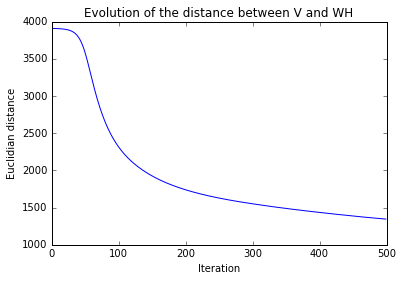

In [24]:
plt.plot(np.arange(len(err)),err)
plt.xlabel("Iteration")
plt.ylabel("Euclidian distance")
plt.title("Evolution of the distance between V and WH")

In [25]:
MSE = mean_squared_error(R_train, W.dot(H))
RMSE = np.sqrt(MSE)

In [26]:
RMSE

7.0869901861758402

In [36]:
H = non_negative_threshold(np.random.randn(k, m))
W = non_negative_threshold(np.random.randn(n,k))

In [37]:
MSE = mean_squared_error(R_train, W.dot(H))
RMSE = np.sqrt(MSE)

In [38]:
RMSE

11.786352258408073

In [42]:
H = np.ones((k, m))
W = non_negative_threshold(np.random.randn(n,k))

In [43]:
MSE = mean_squared_error(R_train, W.dot(H))
RMSE = np.sqrt(MSE)

In [44]:
RMSE

9.8615501841236597

## Comments:
- Convergence is fast: it converges after 200 iterations.
- The running time is also fast: 5.75 s
- RMSE seems good as random predictions give a worse RMSE.

# __Kullback-Leibler NMF__

Here the problem setting is similar, the only diference resides in the distance minimized:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }KL(V,WH)\text{ under constraints } W,H>0
$$


Here again, Lee and Seung propose a multiplicative update rule rewritten using a similar paper "MULTIPLICATIVE UPDATE RULES FOR NONNEGATIVE MATRIX FACTORIZATION WITH CO-OCCURRENCE CONSTRAINTS" (http://sig.umd.edu/publications/Tjoa_ICASSP2_201003.pdf)

$$
H \leftarrow H\odot \frac{W^T\frac{V}{WH}}{W^T\mathbb{1}^n}
$$

$$
W \leftarrow W\odot \frac{\frac{V}{WH}H^T}{\mathbb{1}^mH^T}
$$

with $\odot$ the element-wise matrix product

In [51]:
def kl_solver(V,W,H,t=100,verbose=False):
    
    def update_h(V,W,H):
        n,m = V.shape
        unit_vector = np.ones((n,m))
        factor1 = np.dot(W.T,V/np.dot(W,H))
        factor2 = np.dot(W.T,unit_vector)
        return H*factor1/factor2

    def update_w(V,W,H):
        n,m = V.shape
        unit_vector = np.ones((n,m))
        factor1 = np.dot(V/np.dot(W,H),H.T)
        factor2 = np.dot(unit_vector,H.T)
        return W*factor1/factor2
    

    def error(V,W,H):
        return lin.norm(V-np.dot(W,H))
    
    
    err=[]
    for i in range(t):
        W_new = update_w(V,W,H)
        W = W_new
        H_new = update_h(V,W,H)
        H = H_new
        if verbose==True:
            print error(V,W,H)
        err.append(error(V,W,H))
    
    return W,H,err

In [52]:
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n, k))

In [53]:
%%time

W,H,err = kl_solver(V,W,H,iterations)

Wall time: 9.3 s


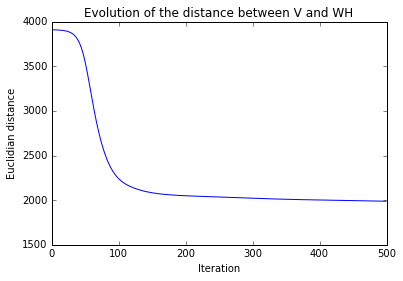

In [54]:
plt.plot(np.arange(len(err)),err)
plt.xlabel("Iteration")
plt.ylabel("Euclidian distance")
plt.title("Evolution of the distance between V and WH")

In [55]:
MSE = mean_squared_error(R_train, W.dot(H))
RMSE = np.sqrt(MSE)


In [56]:
RMSE

8.7058888277608251

In [276]:
np.linalg.norm(W, ord ='fro')

11.167427340794898

## Comments:
- Convergence is very fast: it converges after only 100 iterations.
- The running time is slower: 9.3 s
- RMSE is not very good compared to the first solver. The 2nd algorithm seems to overfit.

## Conclusion:
### Advantages
- Convergence for both algorithms is fast, and the Kullback-Leibler Solver is almost twice as fast as the Least-Square Solver.
- The running time for both algorithms is quite fast (ODG: )

### Drawbacks
- Compared to other results with the Jester dataset, we should have obtained a RMSE score ranked between 7 and 4. To prove this assumption, we noticed that, given 2 random matrices $W$ and $H$, the RMSE was lower than for our 2 NMF algorithms.
- This is due to overfitting. The matrix factorization can overfit for users with few (no more than $K$) ratings: assuming that the feature vectors $H$ of the items  rated by the user are linearly independent and $H$ does not change, there exists a user feature vector $W_u$ with zero training error. Thus, there is a potential for overfitting, if $\eta$ and the extent of the change in $H$ are both small.
- A common way to avoid overfitting is to apply regularization by fixing the dictionary $W$ and by penalizing the square of the Euclidean norm of the weights, i.e. the features matrix of items $H$. NMF induces sparsity a but, but it is not enough to avoid overfitting.
- Another drawback is that these 2 algorithms cannot be used for real data, that is to say, they are not scalable. Indeed, the Jester dataset is very small compared to MovieLens for example. In addition, we have only taken a small part of this dataset.
- Finally, the 2 algorithms don't deal with missing values: we can only measure the RMSE if the rating matrix is dense. However, this never appears with real data.

# Second part: Link with the paper K-Dimensional Coding Schemes in Hilbert Spaces

In order to link the NMF to the paper, let's take a look at the reconstruction error defined in the paper:
$$ f_T(x) = \min_{y \in Y}{\| x - T y\|^2} $$
and
$$ \hat{y} = \text{arg } \min_{y \in Y}{\| x - T y\|^2} $$

To approximate $\mathbb{E}_{x \text{ ~ } \mu} f_T(x)$, we use the empirical risk defined as follows: 
$$\frac{1}{m} \sum \limits_{i=1}^m f_T(x_i)$$
which corresponds to the MSE in our case, with $ x_i$ a user i of the rating matrix $R$

For NMF coding scheme, it is proved that the "regret" $ \mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i)$ is bounded, with at least probability $1 - \delta$ as follows:

$$\mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i) \leq \frac{K}{\sqrt{m}}\left(14 \| \mathcal{T} \|_{Y} + \frac{b}{2} \sqrt{\ln{16 m \| \mathcal{T}}\|_Y^2} \right) + b \sqrt{\frac{\ln{1/\delta}}{2 m}}$$
with the following notations:
$$\mathcal{T} = \{T: T \in \mathcal{L}(\mathbb{R}^K, H), \|T e_k \| = 1, \langle T e_k , T e_l\rangle \geq 0, 1 \leq k,l \leq K \}$$

$$ \| \mathcal{T} \|_Y = \sup_{T \in \mathcal{T}}{\| T \|_Y} = \sup_{T \in \mathcal{T}}{\sup_{y \in Y}{\| T y\|}} $$

This is a proof of the convergence of our algorithms. Indeed it immediately implies uniform convergence in probability.

Here $T$ refers to the matrix $W$ - i.e. the dictionary $D$ we defined in the introduction. Let's check whether $W$ satisfy the properties required in the hypothesis:
 - Given that $W$ is a positive matrix, it satifies the conditions $ \langle W e_k , W e_l\rangle \geq 0, 1 \leq k,l \leq 70 $.
 - $\|W e_k \| \approx 1, 1 \leq k \leq 70$. Indeed:

### Least-Square Solver

In [62]:
V = R_test.copy()
n,m = V.shape
k = 70
iterations = 500
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n,k))
W,H,err = ls_solver(V,W,H,iterations)

In [76]:
for j in range(W.shape[1]):
    print ("Norm of column %d: " % j) ,  np.linalg.norm(W[:,j], ord = 2)

Norm of column 0:  1.3985850952
Norm of column 1:  0.998241035828
Norm of column 2:  1.72506609504
Norm of column 3:  1.58221194129
Norm of column 4:  1.47005354001
Norm of column 5:  1.32225609726
Norm of column 6:  1.31890566993
Norm of column 7:  1.70596567399
Norm of column 8:  1.38241253814
Norm of column 9:  1.23122887857
Norm of column 10:  1.41073694138
Norm of column 11:  1.20363722945
Norm of column 12:  1.49338685499
Norm of column 13:  1.1990835909
Norm of column 14:  1.33311646003
Norm of column 15:  1.58139065052
Norm of column 16:  1.57766343388
Norm of column 17:  1.41127822659
Norm of column 18:  1.50142833847
Norm of column 19:  1.3842879854
Norm of column 20:  1.33100805053
Norm of column 21:  1.11407641039
Norm of column 22:  1.33265710946
Norm of column 23:  1.41863387635
Norm of column 24:  1.35505420255
Norm of column 25:  1.36422207547
Norm of column 26:  1.39493474621
Norm of column 27:  1.41770862127
Norm of column 28:  1.36457104831
Norm of column 29:  1.3803

### Kullback-Leibler Solver

In [77]:
V = R_test.copy()
n,m = V.shape
k = 70
iterations = 500
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n,k))
W,H,err = kl_solver(V,W,H,iterations)

In [78]:
for j in range(W.shape[1]):
    print ("Norm of column %d: " % j) ,  np.linalg.norm(W[:,j], ord = 2)

Norm of column 0:  1.47279310423
Norm of column 1:  1.62778248731
Norm of column 2:  1.14866280956
Norm of column 3:  1.25904924263
Norm of column 4:  1.35587655604
Norm of column 5:  1.5104290751
Norm of column 6:  1.49384253434
Norm of column 7:  1.37784581972
Norm of column 8:  1.51946618142
Norm of column 9:  1.68194205381
Norm of column 10:  1.29927824895
Norm of column 11:  1.38778289358
Norm of column 12:  1.38309419013
Norm of column 13:  1.45861430178
Norm of column 14:  1.38974469203
Norm of column 15:  1.45997425027
Norm of column 16:  1.46615159815
Norm of column 17:  1.41331561201
Norm of column 18:  1.15663516734
Norm of column 19:  1.46024616625
Norm of column 20:  1.53083620917
Norm of column 21:  1.44149884773
Norm of column 22:  1.58931060511
Norm of column 23:  1.57523418427
Norm of column 24:  1.62703320033
Norm of column 25:  1.26825428218
Norm of column 26:  1.46133530719
Norm of column 27:  1.418140273
Norm of column 28:  1.47069349832
Norm of column 29:  1.48944

$\| \mathcal{T} \|_Y = \sqrt{K} $ and $b = 1$ so in our case, the bound becomes:
    $$\mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i) \leq \frac{K}{\sqrt{m}}\left(14 \sqrt{K} + \sqrt{\ln{16 m K}} \right) + \sqrt{\frac{\ln{1/\delta}}{2 m}}$$

Since $K = 70$, $m = 3112$ and we take $\delta = 0.05$ (the inequality is verified with probability $0.95$):


In [94]:
B =(70 / np.sqrt(3112))*(14 * np.sqrt(70) + np.sqrt(np.log(15 * 3112 * 70)) + np.sqrt(np.log(1/0.95)/(2 * 3112)))
B

151.842397802297

which means
$$\mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i) \leq 151.84$$ 

To clarify some points, this bound doesn't require that $T e_k$ be positive: it only requires that $\langle T e_k, T e_l\rangle \geq 0$

# Third part: Online Structured Dictionary Learning

## 3. CF

# TODO: Put some bound from the paper

In [14]:
d_alpha = 100

In [15]:
ratings.shape

(24983L, 100L)

In [17]:
R_test.shape

(4983L, 100L)

# Initialisation de l'entrée dans l'algo

## On initialise D, $\alpha$, etc. 

In [124]:
N, d_x = R_train.shape

In [123]:
np.zeros(2,2)

TypeError: data type not understood

In [131]:
### Initlialize of parameters 
#D = np.random.randn(d_x,d_alpha)
D = np.ones((d_x, d_alpha))
alpha = np.random.randn(d_alpha)
T_alpha = 5
epsilon = 10**(-5)
eta = 0.5
kappa = 1. / (2**10)
#d_G = np.ones(d_alpha)
d_G = group_structure(d_alpha, struct='lasso', nb_group=10)

In [23]:
d_G[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [126]:
alpha

array([ -2.84747649e-01,   8.11172050e-01,  -3.35750806e-01,
        -1.12404880e+00,  -2.11700797e+00,   1.53686972e-01,
        -1.13571637e-01,   6.34650571e-04,  -1.57193346e+00,
        -4.43974897e-01,   2.46123279e-02,  -6.30150665e-01,
        -1.61351667e+00,   4.32873320e-02,  -1.18885647e+00,
         1.22877871e-01,  -4.98188002e-02,   2.65509225e-01,
         2.21436049e-01,   8.65187145e-01,   1.36105312e-02,
         9.07371389e-01,   4.98420555e-01,  -3.09835006e-01,
         8.61622053e-03,   1.04723217e-02,  -6.92108324e-01,
        -2.08681447e-01,   2.66401056e+00,   1.25761839e+00,
        -1.05331790e+00,   7.75537849e-01,  -5.58575504e-01,
         3.81421518e-01,   6.12055754e-02,   8.46009397e-01,
        -1.54450499e+00,   2.97788119e-01,   1.43402966e+00,
        -5.42858343e-01,  -1.45433048e+00,  -1.32153065e+00,
        -4.88246422e-01,  -3.86288907e-01,  -7.70457081e-02,
         6.88895056e-02,  -7.59731946e-01,   6.17517613e-01,
        -3.39936550e-01,

## On extrait $x_O$ de $x$, $D_O$ de $D$

In [242]:
## Take 1st row of R_train
x = list(R_train[0].copy())

## Save indexes of observed values
indices = [i for i, item in enumerate(x) if item != 99]

#remove missing values of first row of R_train
x_O = [a for a in x if a != 99]

# save the observed rows of D
D_O = D[np.array(indices),:].copy() 

In [127]:
def min_alpha(x_O, D_O, alpha, eta, d_alpha, T_alpha, epsilon, d_G):
    ## Minimisation on alpha
    for t in range(T_alpha):

        ## Compute z
        norm_G_alpha = []

        for j in d_G:
            norm_G_alpha.append(np.linalg.norm(j * alpha, ord =2))
        coef = (np.linalg.norm(norm_G_alpha, ord = eta) ** (eta - 1))

        norm_G_alpha = np.array(norm_G_alpha)
        norm_G_alpha = np.power(norm_G_alpha, 2 - eta)
        z = norm_G_alpha * coef
        for i, item in enumerate(z):
            z[i] = max(item, epsilon)

        
        ## Compute alpha
        ksi = []
        for j in range(d_alpha):
            coef_ksi = 0.0
            for i, item in enumerate(z):
                coef_ksi += (d_G[i][j])**2 / item 
            ksi.append(coef_ksi)
        
        ### Pour résoudre le pb de progammation quadratique, on utilise cvxopt
        # P = kappa * diag(ksi) + D_O.T.dot(D_O)
        # Q = - D_O.T.dot(x_O)
        P = kappa * np.diag(ksi) + D_O.T.dot(D_O)
        P = cvxopt.matrix(P)

        q = - D_O.T.dot(x_O)
        q = cvxopt.matrix(q)

        sol = cvxopt.solvers.qp(P,q)
        alpha = np.ravel(sol['x'])
    return alpha

In [243]:
alpha = min_alpha(x_O, D_O, alpha, eta, d_alpha, T_alpha, epsilon, d_G)

In [244]:
alpha

array([ -4.42423503e-03,   7.73132758e-01,  -1.92842830e-03,
         6.39557785e-01,   8.44078406e-01,   1.65145383e+00,
        -2.02564547e+00,  -1.38509686e+00,   2.55241164e+00,
         3.58248673e+00,   2.14158321e-01,   1.39804015e+00,
         1.21190967e+00,   1.19172084e-02,  -7.39976438e-01,
        -8.84294653e-01,  -2.61427167e+00,  -9.83050675e-01,
         3.04163367e+00,  -8.99400128e-02,  -1.20852488e-03,
        -2.16870925e-03,   3.13649581e+00,  -7.44198137e-01,
        -2.06542475e-03,  -2.38728310e-01,   1.31282960e+00,
        -6.23508621e-01,   8.72839144e-01,   1.22546233e+00,
         6.13006627e-01,  -1.77600661e+00,  -3.69670619e-01,
         1.35573352e-01,  -8.35067040e-03,   1.52061564e+00,
         1.03232727e+00,  -5.54533526e-01,   1.93495981e+00,
         1.61971959e-02,   2.57337339e+00,   3.58793363e-01,
         9.93485401e-01,  -1.34915583e-02,   2.51974941e+00,
        -1.50184326e+00,  -7.60379104e-01,  -6.34946053e-03,
        -2.33953169e+00,

In [128]:
def testing_model(D, alpha, nb_items_to_remove, R_test, model = 'NMF', missing_value = 99):
    ## Define testing set
    # On définit le testing set, on fait la prédiction et on calcule l'erreur dans 1 même boucle
    
    N = R_test.shape[0]
    MSE = 0.0
    #if model == 'NMF':
     #   XXXXXXXX
    if model == 'OSDL':
        for j, jtem in enumerate(R_test):
            ## Take 1st row of R_train
            x = jtem.copy()

            ## Save indexes of observed values
            indices = [i for i, item in enumerate(x) if item != missing_value]
            indices = np.array(indices)

            # save the observed rows of D
            # we will use for prediction of x_O_pred and compare it to x_O
            D_O_test = D[np.array(indices),:].copy() 

            #remove missing values of first row of R_train
            x_O_test = x[indices]

            #remove nb_items_to_remove values of x_O_test
            index_pred = sorted(np.random.choice(len(x_O_test), len(x_O_test) - nb_items_to_remove, replace = False))
            x_O_pred = x_O_test[index_pred].copy()
            D_O_pred = D[index_pred,:].copy()

            #prediction
            alpha_test = min_alpha(x_O_pred, D_O_pred, alpha, eta, d_alpha, T_alpha, epsilon, d_G)

            MSE += mean_squared_error(x_O_test, D_O_test.dot(alpha_test))

        MSE = MSE / N
        RMSE = np.sqrt(MSE)
    return 'MSE: ',MSE, ' RMSE: ', RMSE
        
    

In [132]:
testing_model(D, alpha, 10, R_test, model = 'OSDL', missing_value = 99)

('MSE: ', 21.379577341578543, ' RMSE: ', 4.6238055042982227)

In [21]:
def group_structure(d_alpha, struct, nb_group=3):
    if struct == 'lasso':
        d_G = []
        for i in range(d_alpha):
            G = np.zeros(d_alpha)
            G[i] = 1
            d_G.append(G)
            
    if struct == 'group_lasso':
        # fonction rand pour donner le nombre d'indices dans chaque partition de {1...d_alpha}
        # Exemple: n paritions
        partition = sorted(np.random.choice(d_alpha, nb_group-1, replace = False))

        ## shuffle les indices
        shuffled_indices = np.random.choice(d_alpha, d_alpha, replace = False)
        
        ## Création des groupes
        x = []
        for i, item in enumerate(partition):
            if i == 0:
                x.append(shuffled_indices[:item])
            elif i == len(partition) - 1:
                x.append(shuffled_indices[partition[i-1]:item])
                x.append(shuffled_indices[item:])
            else:
                x.append(shuffled_indices[partition[i-1]: item])
        d_G = []
        for i, item in enumerate(x):
            G = np.zeros(d_alpha)
            G[item] = 1
            d_G.append(G)
            
    return d_G
    

In [230]:
group_structure(d_alpha, struct='lasso', nb_group=3)[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])